# Télécom Paris IA716 - MS IA 2021/22 - Souhail OUMAMA
# IA716 - Perception pour les systèmes Autonomes  
# <font color='green'>Project 1 : Domain Transfer : From MNIST to SVHN with CycleGAN & SGAN</font>


**- Regarding the Project 1, the objective is to train a GAN that will learn to transform MNIST images into SVHN images.**

**- Once we have succeeded in doing this, we will evaluate how well our GAN performed by training a CNN classifier on the generated images, with , and testing it on the original SVHN test images. For this classification We can consider that we have the MNIST images with annotations**

**- This notebook will treat both tasks separately :**  
*1. Train the GAN and Generate Fake SVHN from MNIST*  
*2. Train a CNN on the Generated SVHN and Test on Original SVHN*

# <font color='red'>0 - Linking Colab to the project folder</font>

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/IA716_CompVision/MNIST-SVHN'
    %cd /content/drive/MyDrive/Colab Notebooks/IA716_CompVision/MNIST-SVHN

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/IA716_CompVision/MNIST-SVHN


----
# <font color='red'>1. Making the neccessary imports</font>

In [2]:
import os
import pickle
import scipy.io
import scipy.misc
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.utils import resample

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.backends import cudnn
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch import optim

cudnn.benchmark = True 

# <font color='red'>2 - The Data

----
## <font color='orange'>2.1 - Import the MNIST and SVHN datasets

In [3]:
## Defining the Transforms functions to resize and normalize the images at the time of download

transform_svhn = transforms.Compose([
                    transforms.Resize(32),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
transform_mnist = transforms.Compose([
                  transforms.Resize(32),
                  transforms.ToTensor(),
                  transforms.Normalize(0.5, 0.5)])

In [4]:
## Defining the Inverse Transforms function to plot the images

invTransform_mnist = transforms.Compose([ transforms.Normalize(mean = 0,
                                                     std = 1/0.5,),
                                transforms.Normalize(mean = -0.5,
                                                     std = 1,),
                                transforms.RandomHorizontalFlip(p=1)
                               ])

invTransform_svhn = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],
                                                     std = [ 1., 1., 1. ]),
                                transforms.RandomHorizontalFlip(p=1)
                               ])

def invTrans_mnist(img):
  img = invTransform_mnist(img)
  img = transforms.functional.rotate(img, angle=90)
  return img.T.expand(-1,-1, 3)

def invTrans_svhn(img):
  img = invTransform_svhn(img)
  img = transforms.functional.rotate(img, angle=90)
  return img.T

In [5]:
## Download the datasets

svhn  = datasets.SVHN(root =ROOT_PATH+'/svhn' , download=True, transform=transform_svhn)
mnist = datasets.MNIST(root=ROOT_PATH+'/mnist', download=True, transform=transform_mnist)

Using downloaded and verified file: /content/drive/MyDrive/Colab Notebooks/IA716_CompVision/MNIST-SVHN/svhn/train_32x32.mat


## <font color='orange'>2.2 - Plot samples images from the DataSets

**We will plot a few examples of each dataset to get a feel or what our data looks like**

----
### <font color='blue'>MNIST

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)


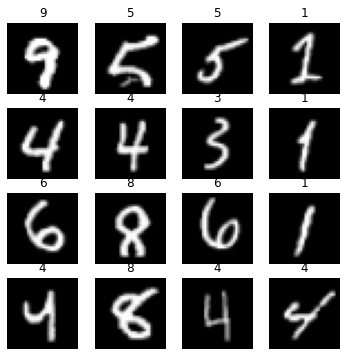

In [6]:
# Get a smaller subset of images for more variety
mnist_small = resample(mnist, 
                 replace=True,     
                 n_samples=100) 

# plot 16 images
plt.subplots(figsize=(6,6))
for i in range(16):
	plt.subplot(4, 4, 1 + i)
	plt.axis('off')
	plt.imshow(invTrans_mnist(mnist_small[i][0]))
	plt.title(mnist_small[i][1])

----
### <font color='blue'>SVHN

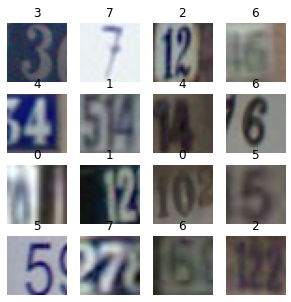

In [7]:
# Get a smaller subset of images for more variety
SVHN_small = resample(svhn, 
                 replace=True,     
                 n_samples=100) 

# plot 16 images
plt.subplots(figsize=(5,5))
for i in range(16):
	plt.subplot(4, 4, 1 + i)
	plt.axis('off')
	plt.imshow(invTrans_svhn(SVHN_small[i][0]))
	plt.title(SVHN_small[i][1])

----
# <font color='red'>3 - The Generative Adversarial Networks

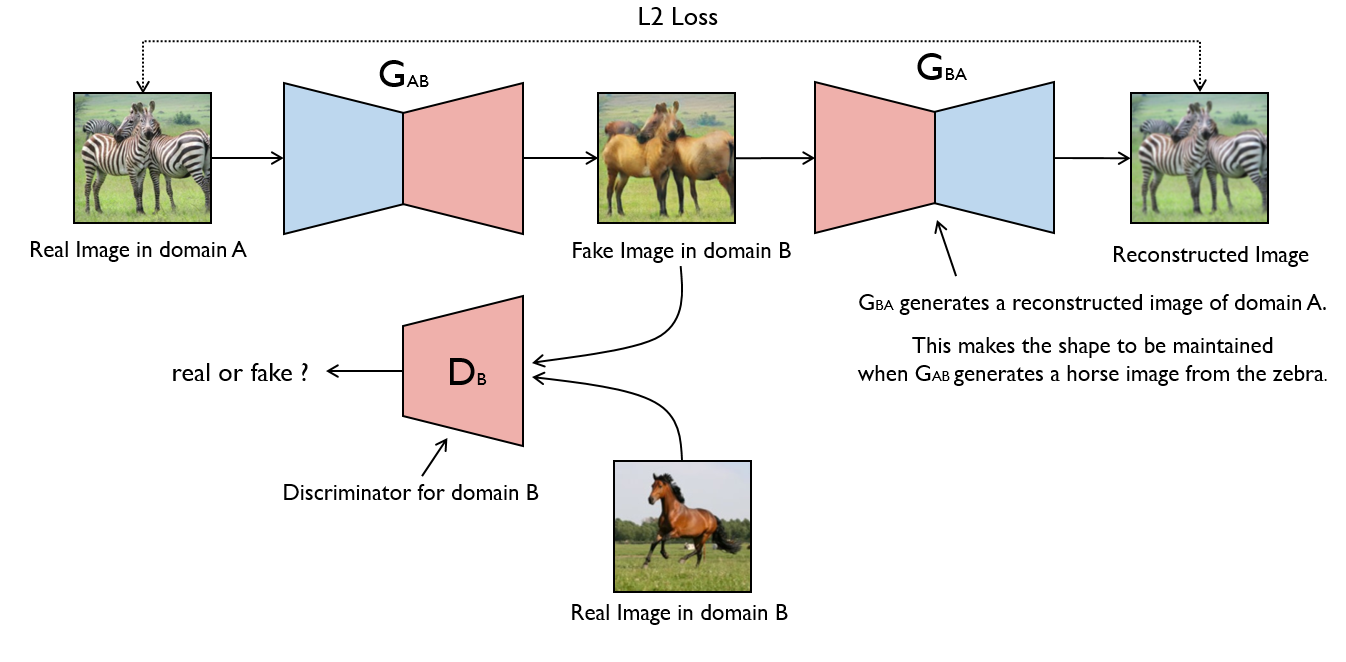

**We will be following this described architecture to construct our GAN.**  
**The code is inspired by the following repo : https://github.com/yunjey/mnist-svhn-transfer**

## <font color='orange'>3.1 - The Architecture of the GAN

In [8]:
## Creating a custom Convolutional Layer for the encoding

def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

In [9]:
## Creating a custom deconvolution layer for the decoding

def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

In [10]:
## Creating the first generator : from MNIST to SVHN 

class G12(nn.Module):
    def __init__(self, conv_dim=64):
        super(G12, self).__init__()
        # encoding blocks
        self.conv1 = conv(1, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        
        # residual blocks
        self.conv3 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.conv4 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        
        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 3, 4, bn=False)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)    # (?, 128, 8, 8)
        
        out = F.leaky_relu(self.conv3(out), 0.05)    # ( " )
        out = F.leaky_relu(self.conv4(out), 0.05)    # ( " )
        
        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 16, 16)
        out = torch.tanh(self.deconv2(out))              # (?, 3, 32, 32)
        return out

In [11]:
## Creating the first generator : from SVHN to MNIST 

class G21(nn.Module):
    """Generator for transfering from svhn to mnist"""
    def __init__(self, conv_dim=64):
        super(G21, self).__init__()
        # encoding blocks
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        
        # residual blocks
        self.conv3 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.conv4 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        
        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 1, 4, bn=False)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)    # (?, 128, 8, 8)
        
        out = F.leaky_relu(self.conv3(out), 0.05)    # ( " )
        out = F.leaky_relu(self.conv4(out), 0.05)    # ( " )
        
        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 16, 16)
        out = torch.tanh(self.deconv2(out))              # (?, 1, 32, 32)
        return out

In [12]:
## Creating the first Discriminator for MNIST

class D1(nn.Module):
    """Discriminator for mnist."""
    def __init__(self, conv_dim=64, use_labels=True):
        super(D1, self).__init__()
        self.conv1 = conv(1, conv_dim, 4, bn=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        n_out = 11 if use_labels else 1
        self.fc = conv(conv_dim*4, n_out, 4, 1, 0, False)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)    # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 8, 8)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 4, 4)
        out = self.fc(out).squeeze()
        return out

In [13]:
## Creating the first Discriminator for SVHN

class D2(nn.Module):
    """Discriminator for svhn."""
    def __init__(self, conv_dim=64, use_labels=True):
        super(D2, self).__init__()
        self.conv1 = conv(3, conv_dim, 4, bn=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        n_out = 11 if use_labels else 1
        self.fc = conv(conv_dim*4, n_out, 4, 1, 0, False)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)    # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 8, 8)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 4, 4)
        out = self.fc(out).squeeze()
        return out

## <font color='orange'>3.2 - Training the GAN

### <font color='blue'>Defining the dataloaders : Preparing the data for the GAN


In [14]:
svhn_loader = torch.utils.data.DataLoader(dataset=svhn,
                                              batch_size=64,
                                              shuffle=True,
                                              num_workers=2)

mnist_loader = torch.utils.data.DataLoader(dataset=mnist,
                                            batch_size=64,
                                            shuffle=True,
                                            num_workers=2)

### <font color='blue'>Defining the hyperparameters

In [15]:
# Defining useful variables
num_classes = 10
beta1 = 0.5
beta2 = 0.999
g_conv_dim = 64
d_conv_dim = 64
train_iters = 40000
batch_size = 64
lr = 0.0002
log_step = 10
sample_step = 500

# Setting the paths to the folders where the samples and models will be saved
sample_path = ROOT_PATH+'/samples'
model_path = ROOT_PATH+'/models'

### <font color='blue'>Building the Generators & Discriminators

In [16]:
# Setting up the Generator and Discriminator models
g12 = G12(conv_dim = g_conv_dim)
g21 = G21(conv_dim = g_conv_dim)
d1 = D1(conv_dim = d_conv_dim)
d2 = D2(conv_dim = d_conv_dim)

# Setting the parameters for the Generator and Discriminator
g_params = list(g12.parameters()) + list(g21.parameters())
d_params = list(d1.parameters()) + list(d2.parameters())

# Defining the optimizers for the Generator and Discriminator (we will be using Adam here)
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_optimizer = optim.Adam(d_params, lr, [beta1, beta2])

# Transfer the models to the GPU for faster computing
if torch.cuda.is_available():
    g12.cuda()
    g21.cuda()
    d1.cuda()
    d2.cuda()

### <font color='blue'>Useful Functions

In [17]:
# Function to merge original and generated images in grid form
def merge_images(sources, targets, k=5):
        _, _, h, w = sources.shape
        row = int(np.sqrt(batch_size))
        merged = np.zeros([3, row*h, row*w*2])
        for idx, (s, t) in enumerate(zip(sources, targets)):
            i = idx // row
            j = idx % row
            merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
            merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
        return merged.transpose(1, 2, 0)

In [18]:
def to_gpu(x):
    """Converts numpy to variable."""
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def to_cpu(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    return x.data.numpy()

def reset_grad():
    """Zeros the gradient buffers."""
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()

def Criterion(out, labels):
    return torch.mean(out**2)

### <font color='blue'>Defining the training function

**We will be constructing our Training function to be able to handle two different architectures :**   
 - **CycleGAN** : The discriminator in a traditional GAN is trained to predict whether a given image is real (from the dataset) or fake (generated), allowing it to learn features from unlabeled images. The discriminator can then be used via transfer learning as a starting point when developing a classifier for the same dataset, allowing the supervised prediction task to benefit from the unsupervised training of the GAN.
 - **SGAN** : In the Semi-Supervised GAN, the discriminator model is updated to predict K+1 classes, where K is the number of classes in the prediction problem and the additional class label is added for a new “fake” class. It involves directly training the discriminator model for both the unsupervised GAN task and the supervised classification task simultaneously.  
*(https://machinelearningmastery.com/semi-supervised-generative-adversarial-network/)*

In [19]:
def train(gan='cyclegan', use_labels = True):
    svhn_iter = iter(svhn_loader)
    mnist_iter = iter(mnist_loader)
    iter_per_epoch = min(len(svhn_iter), len(mnist_iter))
    
    # fixed mnist and svhn for sampling
    fixed_svhn  = to_gpu(svhn_iter.next()[0])
    fixed_mnist = to_gpu(mnist_iter.next()[0])
    
    if gan =='cyclegan':
      use_reconst_loss = True
      criterion = Criterion
    elif gan =='sgan':
      use_labels = True
      criterion = nn.CrossEntropyLoss()
    
    for step in range(train_iters+1):
        # reset data_iter for each epoch
        if (step+1) % iter_per_epoch == 0:
            mnist_iter = iter(mnist_loader)
            svhn_iter = iter(svhn_loader)
        
        # load svhn and mnist dataset
        svhn, s_labels = svhn_iter.next() 
        svhn, s_labels = to_gpu(svhn), to_gpu(s_labels).long().squeeze()
        mnist, m_labels = mnist_iter.next() 
        mnist, m_labels = to_gpu(mnist), to_gpu(m_labels)

        mnist_fake_labels = to_gpu(torch.Tensor([num_classes]*svhn.size(0)).long())
        svhn_fake_labels  = to_gpu(torch.Tensor([num_classes]*mnist.size(0)).long())
        
        #############################
        ## Train the Discriminator ##
        #############################
        
        # First we train it on the real images
        reset_grad()
        out = d1(mnist)
        d1_loss = criterion(out, m_labels)

        out = d2(svhn)
        d2_loss = criterion(out, s_labels)
        
        d_mnist_loss = d1_loss
        d_svhn_loss = d2_loss
        d_real_loss = d1_loss + d2_loss
        d_real_loss.backward()
        d_optimizer.step()
        
        # Then on the fake images
        reset_grad()
        fake_svhn = g12(mnist)
        out = d2(fake_svhn)
        d2_loss = criterion(out, svhn_fake_labels)
        
        fake_mnist = g21(svhn)
        out = d1(fake_mnist)
        d1_loss = criterion(out, mnist_fake_labels)
        
        d_fake_loss = d1_loss + d2_loss
        d_fake_loss.backward()
        d_optimizer.step()
        
        #############################
        ##   Train the Generator   ##
        #############################
        
        # MNIST -> SVHN -> MNIST Cycle
        reset_grad()
        fake_svhn = g12(mnist)
        out = d2(fake_svhn)
        reconst_mnist = g21(fake_svhn)
        g_loss = criterion(out, m_labels) 

        if gan =='cyclegan':
            g_loss += torch.mean((mnist - reconst_mnist)**2)

        g_loss.backward()
        g_optimizer.step()

        # SVHN -> MNIST -> SVHN Cycle
        reset_grad()
        fake_mnist = g21(svhn)
        out = d1(fake_mnist)
        reconst_svhn = g12(fake_mnist)
        g_loss = criterion(out, s_labels) 

        if gan =='cyclegan':
          g_loss += torch.mean((svhn - reconst_svhn)**2)

        g_loss.backward()
        g_optimizer.step()
        
        # print the log info
        if (step+1) % log_step == 0:
            print('Step [%d/%d], d_real_loss: %.4f, d_mnist_loss: %.4f, d_svhn_loss: %.4f, '
                  'd_fake_loss: %.4f, g_loss: %.4f'
                  %(step+1, train_iters, d_real_loss, d_mnist_loss,
                    d_svhn_loss, d_fake_loss, g_loss))

        # save the sampled images
        if (step+1) % sample_step == 0:
            fake_svhn = g12(fixed_mnist)
            fake_mnist = g21(fixed_svhn)
            
            mnist, fake_mnist = to_cpu(fixed_mnist), to_cpu(fake_mnist)
            svhn , fake_svhn = to_cpu(fixed_svhn), to_cpu(fake_svhn)
            
            merged = merge_images(mnist, fake_svhn)
            path = os.path.join(sample_path, 'sample-%d-m-s.png' %(step+1))
            scipy.misc.imsave(path, merged)
            print ('saved %s' %path)
            
            merged = merge_images(svhn, fake_mnist)
            path = os.path.join(sample_path, 'sample-%d-s-m.png' %(step+1))
            scipy.misc.imsave(path, merged)
            print ('saved %s' %path)
        
        if (step+1) % 5000 == 0:
            # save the model parameters for each epoch
            g12_path = os.path.join(model_path, 'g12-%d.pkl' %(step+1))
            g21_path = os.path.join(model_path, 'g21-%d.pkl' %(step+1))
            d1_path = os.path.join(model_path, 'd1-%d.pkl' %(step+1))
            d2_path = os.path.join(model_path, 'd2-%d.pkl' %(step+1))
            torch.save(g12.state_dict(), g12_path)
            torch.save(g21.state_dict(), g21_path)
            torch.save(d1.state_dict(), d1_path)
            torch.save(d2.state_dict(), d2_path)

In [20]:
#train(gan='cyclegan')

**Due to the long training time of the models, it was performed on the accesible GPU virtual machines at Télécom Paris.**  
**The trained models are downloaded back and saved in our /models folder**

## <font color='orange'>3.3 - Inspecting the results

In [21]:
%cd models

/content/drive/MyDrive/Colab Notebooks/IA716_CompVision/MNIST-SVHN/models


**We ran the model at 100000 iterations, to get as clear an image of the training as we can**  
**We noticed that the model converges at around the 20k-40k range, and gives its best results at around 35k iterations, producing decent images, then diverges at the higher iterations**  
- **CycleGAN :** Produces real looking digits numbers, but performs pretty poorly on the semantics side, which means that the generated images do not correspond to their initial labels.
- **SGAN :** Performs a little bit better than the CycleGAN, as the supplementary information as the model trains in a manner that groups images of the same label in a similar latent space, making it easier to tweak the learning for every digit.  

**We will consider this latter model for our case, and see how well it performs on conserving the semantic information contained in the images**

In [22]:
svhn_loader = torch.utils.data.DataLoader(dataset=svhn,
                                              batch_size=100,
                                              shuffle=True,
                                              num_workers=2)

mnist_loader = torch.utils.data.DataLoader(dataset=mnist,
                                            batch_size=100,
                                            shuffle=True,
                                            num_workers=2)
svhn_iter = iter(svhn_loader)
mnist_iter = iter(mnist_loader)

In [23]:
len(svhn_loader)

733

In [24]:
## Load the trained models 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MNIST -> SVHN
g12 = G12()
checkpoint = torch.load('g12-30000.pkl', map_location ='cuda:0')
g12.load_state_dict(checkpoint)
g12.to(device);

# SVHN -> MNIST
g21 = G21()
checkpoint = torch.load('g21-45000.pkl', map_location ='cuda:0')
g21.load_state_dict(checkpoint)
g21.to(device);

In [25]:
# Check if models are on gpu
next(g12.parameters()).is_cuda, next(g21.parameters()).is_cuda


(True, True)

In [26]:
# fixed mnist and svhn for sampling

images_svhn, labels_svhn  = svhn_iter.next()
fixed_svhn  = to_gpu(images_svhn)
labels_svhn = to_cpu(labels_svhn)

images_mnist, labels_mnist = mnist_iter.next()
fixed_mnist = to_gpu(images_mnist)
labels_mnist = to_cpu(labels_mnist)

# Generating the images
fake_svhn = g12(fixed_mnist)
fake_mnist = g21(fixed_svhn)

# Reconstructing the images in the original domain for comparison
recon_mnist = g21(fake_svhn)
recon_svhn = g12(fake_mnist)

### <font color='blue'>Generated SVHN

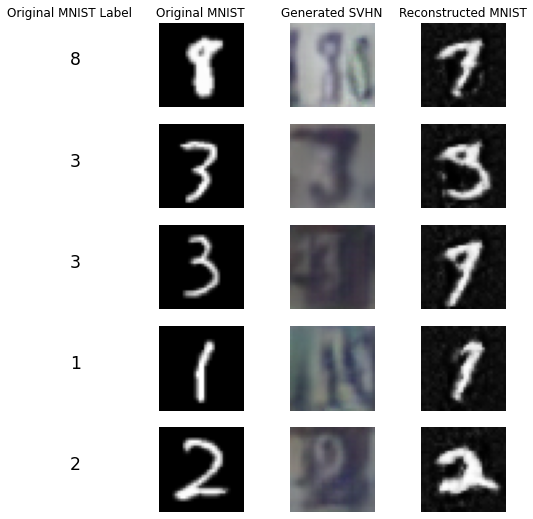

In [27]:
idx = random.sample(range(len(fixed_svhn)), 5)


plt.subplots(5,4,figsize=(9,9))
for i in range(len(idx)):
  plt.subplot(5,4,4*i+1)
  plt.axis('off')
  plt.text(0.5, 0.5, labels_mnist[idx[i]], size='xx-large')
  if i==0 : plt.title('Original MNIST Label')

  plt.subplot(5,4,4*i+2)
  plt.axis('off')
  plt.imshow(invTrans_mnist(images_mnist[idx[i]].detach()))
  if i==0 : plt.title('Original MNIST')

  plt.subplot(5,4,4*i+3)
  plt.axis('off')
  plt.imshow(invTrans_svhn(fake_svhn[idx[i]].cpu().detach()))
  if i==0 : plt.title('Generated SVHN')

  plt.subplot(5,4,4*i+4)
  plt.axis('off')
  plt.imshow(invTrans_mnist(recon_mnist[idx[i]].cpu().detach()))
  if i==0 : plt.title('Reconstructed MNIST')

**As we can see on these examples of our generated images, the model performed well on catching the style of the SVHN label, and we could decypher the digits with our bare eyes 80% to 100% of the times.**  

**The reconstruction loss shows that our model can indeed go back to the original domain in almost half the cases, which shows that there is much room for improvement.**

### <font color='blue'>Generated MNIST

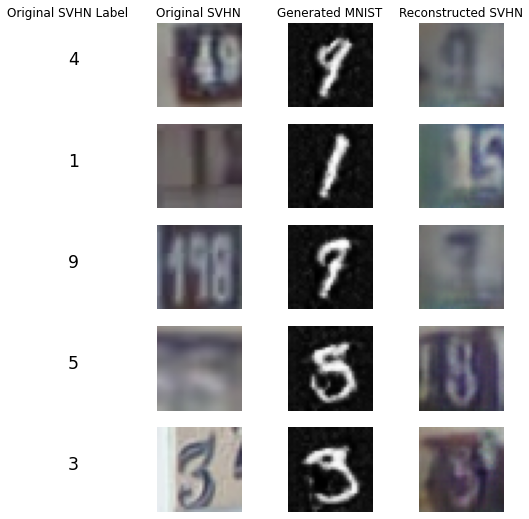

In [28]:
idx = random.sample(range(len(fixed_svhn)), 5)

plt.subplots(5,4,figsize=(9,9))
for i in range(len(idx)):

  plt.subplot(5,4,4*i+1)
  plt.axis('off')
  plt.text(0.5, 0.5, labels_svhn[idx[i]], size='xx-large')
  if i==0 : plt.title('Original SVHN Label')

  plt.subplot(5,4,4*i+2)
  plt.axis('off')
  plt.imshow(invTrans_svhn(fixed_svhn[idx[i]].cpu().detach()))
  if i==0 : plt.title('Original SVHN')

  plt.subplot(5,4,4*i+3)
  plt.axis('off')
  plt.imshow(invTrans_mnist(fake_mnist[idx[i]].cpu().detach()))
  if i==0 : plt.title('Generated MNIST')

  plt.subplot(5,4,4*i+4)
  plt.axis('off')
  plt.imshow(invTrans_svhn(recon_svhn[idx[i]].cpu().detach()))
  if i==0 : plt.title('Reconstructed SVHN')

---- 
## <font color='orange'>3.4 - Creating the Fake SVHN dataset

**We will try to recreate a fake SVHN dataset, by providing our saved model with batches of 2000 images and saving them to a *'.npy'* file.**  

**We limited ourselves to 20000 images total as the computational constraints of Google Colab. We tested a classification on the 20k images from the orignial SVHN dataset and eneded up with an accuracy of 89%, which would be great if achieved here.**

In [83]:
mnist_loader = torch.utils.data.DataLoader(dataset=mnist,
                                            batch_size=2000,
                                            shuffle=True)

mnist_iter = iter(mnist_loader)
len(mnist_iter)

30

**PS. The below code was run on a separate notebook to bypass the limits of GPU RAM imposed by Colab, as we don't have enough resources on this notebook.**   
**The files were saved and will be retrieved later on.**

In [ ]:
# Go over the batches, transforming them one by one and adding them to a list
svhn_images, mnist_labels = [], []
for i in range(10):

  images_mnist_cpu, labels_mnist = mnist_iter.next()
  images_mnist_gpu = to_gpu(images_mnist_cpu)
  fake_svhn = g12(images_mnist_gpu)
  svhn_images.append(fake_svhn)
  mnist_labels.append(labels_mnist)

# Concatenate the obtained list to get one full dataset
svhn_images = torch.cat(svhn_images, dim=0)
mnist_labels = torch.cat(mnist_labels, dim=0)

svhn_images.shape, mnist_labels.shape

In [ ]:
# Transform our sets into numpy to save them for later usage.
svhn_images = svhn_images.cpu().detach().numpy()
mnist_labels = mnist_labels.cpu().numpy()

svhn_images.shape, mnist_labels.shape

In [ ]:
%cd ..

In [ ]:
np.save('generated_svhn', svhn_images, allow_pickle=True, fix_imports=True)

In [ ]:
np.save('generated_labels', mnist_labels, allow_pickle=True, fix_imports=True)

----
# <font color='Red'>4 - The Classification

**Now that we have finished the generation part of the project, we will evaluate how well it performed in keeping the semantic information of the images, as explained above**

**PS. As I wanted to get a better grasp of how to use both Deep Learning frameworks (Torch and Keras), i have decided to perform this task using Keras, basing part ot the code from the following Kaggle resource:**  
*https://www.kaggle.com/code/dimitriosroussis/svhn-classification-with-cnn-keras-96-acc/notebook*

In [29]:
%matplotlib inline

import numpy as np
import seaborn as sns
import  matplotlib.pyplot as plt
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

np.random.seed(42)

---- 
## <font color='orange'>4.1 - Getting and prepping the Train & Test sets

In [38]:
## Load images and labels

# Train_images from our generated data 
train_images = np.load('generated_svhn.npy')
train_images = np.moveaxis(train_images, 1, -1)
train_images = (train_images * 127.5 + 127.5).astype(int)
train_labels = np.load('generated_labels.npy')


# Test Set from the original SVHN dataset
test_raw = loadmat('test_32x32.mat')
test_images = np.array(test_raw['X'])
test_images = np.moveaxis(test_images, -1, 0)
test_labels = test_raw['y']

In [39]:
# Check the shape of the data

print(train_images.shape)
print(test_images.shape)

(20000, 32, 32, 3)
(26032, 32, 32, 3)


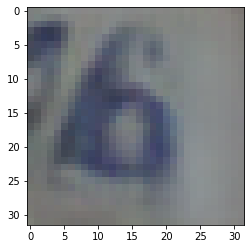

Label:  [1]


In [40]:
# Plot a random image from our Train set and its label
i = 150
plt.imshow((train_images[i]))
plt.show()

print('Label: ', (test_labels[i]))

**We can already see that this generated *' 6 '* was a *' 1 '* originally**.

In [41]:
# Convert train and test images into 'float64' type

train_images = train_images.astype('float64')
test_images = test_images.astype('float64')

# Convert train and test labels into 'int64' type

train_labels = train_labels.astype('int64')
test_labels = test_labels.astype('int64')

In [42]:
# Normalize the images data

print('Min: {}, Max: {}'.format(train_images.min(), train_images.max()))

train_images /= 255.0
test_images /= 255.0

Min: 22.0, Max: 250.0


In [43]:
# One-hot encoding of train and test labels

lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

In [44]:
# Split train data into train and validation sets

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels,
                                                  test_size=0.15, random_state=22)

In [45]:
y_val.shape

(3000, 10)

**In order to get more robust results out of our model, we are going to augment the images in the dataset.**

In [46]:
# Data augmentation
datagen = ImageDataGenerator(rotation_range=8,
                             zoom_range=[0.95, 1.05],
                             height_shift_range=0.10,
                             shear_range=0.15)

---- 
## <font color='orange'>4.2 - Hyperparameterizing the LearningRate

**In order to determine a good learning rate for the optimizer of our model (here, we use the AMSGrad variant of the Adam optimizer), we set a callback in an auxillary model which will gradually increase the learning rate of the optimizer.**

In [47]:
# Define the auxiliary classifier to get the optimal learning rate

keras.backend.clear_session()

aux_model = keras.Sequential([
    Conv2D(32, (3, 3), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', 
                        activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(64, (3, 3), padding='same', 
                           activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(128, (3, 3), padding='same', 
                           activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same',
                        activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),    
    Dense(10,  activation='softmax')
])

lr_schedule = keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-3 * 10**(epoch / 10))
optimizer = keras.optimizers.Adam(lr=1e-3, amsgrad=True)
aux_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                 metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [48]:
# Fit model in order to determine best learning rate

history = aux_model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                              epochs=30, validation_data=(X_val, y_val),
                              callbacks=[lr_schedule])

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


532/532 [==============================] - 19s 17ms/step - loss: 1.2301 - accuracy: 0.5661 - val_loss: 1.0626 - val_accuracy: 0.6393 - lr: 0.0010
Epoch 2/30
532/532 [==============================] - 8s 16ms/step - loss: 0.6873 - accuracy: 0.7772 - val_loss: 1.6362 - val_accuracy: 0.5023 - lr: 0.0013
Epoch 3/30
532/532 [==============================] - 8s 15ms/step - loss: 0.4526 - accuracy: 0.8608 - val_loss: 0.3027 - val_accuracy: 0.9187 - lr: 0.0016
Epoch 4/30
532/532 [==============================] - 8s 16ms/step - loss: 0.3875 - accuracy: 0.8911 - val_loss: 0.2809 - val_accuracy: 0.9180 - lr: 0.0020
Epoch 5/30
532/532 [==============================] - 8s 15ms/step - loss: 0.3730 - accuracy: 0.8926 - val_loss: 0.6493 - val_accuracy: 0.7970 - lr: 0.0025
Epoch 6/30
532/532 [==============================] - 8s 15ms/step - loss: 0.3680 - accuracy: 0.8962 - val_loss: 2.4723 - val_accuracy: 0.3950 - lr: 0.0032
Epoch 7/30
532/532 [==============================] - 8s 16ms/step - loss:

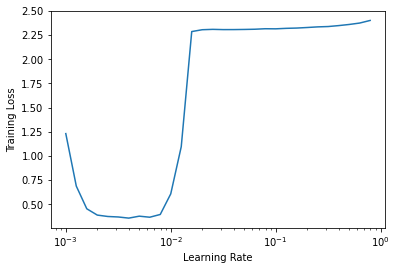

In [49]:
# Plot Learning Rate vs. Loss

plt.semilogx(history.history['lr'], history.history['loss'])
plt.xlabel('Learning Rate')
plt.ylabel('Training Loss')
plt.show()

**We can see that the loss drops rapidly and shoots back up to a relatively flat line.**  
**Thus, it is better to choose a learning rate in the region where the loss is stable; a reasonable choice would be lr = 2e-3).**

---- 
## <font color='orange'>4.3 - Training the model

In [50]:
# Define actual model

keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                           activation='relu',
                           input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), padding='same', 
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(64, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(128, (3, 3), padding='same', 
                           activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), padding='same',
                        activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),    
    keras.layers.Dense(10,  activation='softmax')
])

early_stopping = keras.callbacks.EarlyStopping(patience=8)
optimizer = keras.optimizers.Adam(learning_rate=3e-3, amsgrad=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(
                   '/best_cnn.h5', 
                   save_best_only=True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        1

In [52]:
# Fit model in order to make predictions

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                              epochs=20, validation_data=(X_val, y_val),
                              callbacks=[early_stopping, model_checkpoint])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


266/266 [==============================] - 9s 31ms/step - loss: 1.6979 - accuracy: 0.3705 - val_loss: 2.8521 - val_accuracy: 0.1303
Epoch 2/20
266/266 [==============================] - 8s 29ms/step - loss: 1.2380 - accuracy: 0.5169 - val_loss: 0.7904 - val_accuracy: 0.7553
Epoch 3/20
266/266 [==============================] - 8s 29ms/step - loss: 0.9979 - accuracy: 0.6169 - val_loss: 0.7593 - val_accuracy: 0.7327
Epoch 4/20
266/266 [==============================] - 8s 28ms/step - loss: 0.6956 - accuracy: 0.7664 - val_loss: 1.5262 - val_accuracy: 0.6913
Epoch 5/20
266/266 [==============================] - 8s 29ms/step - loss: 0.4897 - accuracy: 0.8524 - val_loss: 0.4771 - val_accuracy: 0.8757
Epoch 6/20
266/266 [==============================] - 8s 29ms/step - loss: 0.4032 - accuracy: 0.8829 - val_loss: 1.1773 - val_accuracy: 0.6277
Epoch 7/20
266/266 [==============================] - 8s 29ms/step - loss: 0.3200 - accuracy: 0.9064 - val_loss: 0.3457 - val_accuracy: 0.8933
Epoch 8/20

---- 
## <font color='orange'>4.4 - Evaluating the model

In [53]:
# Evaluate train and validation accuracies and losses

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

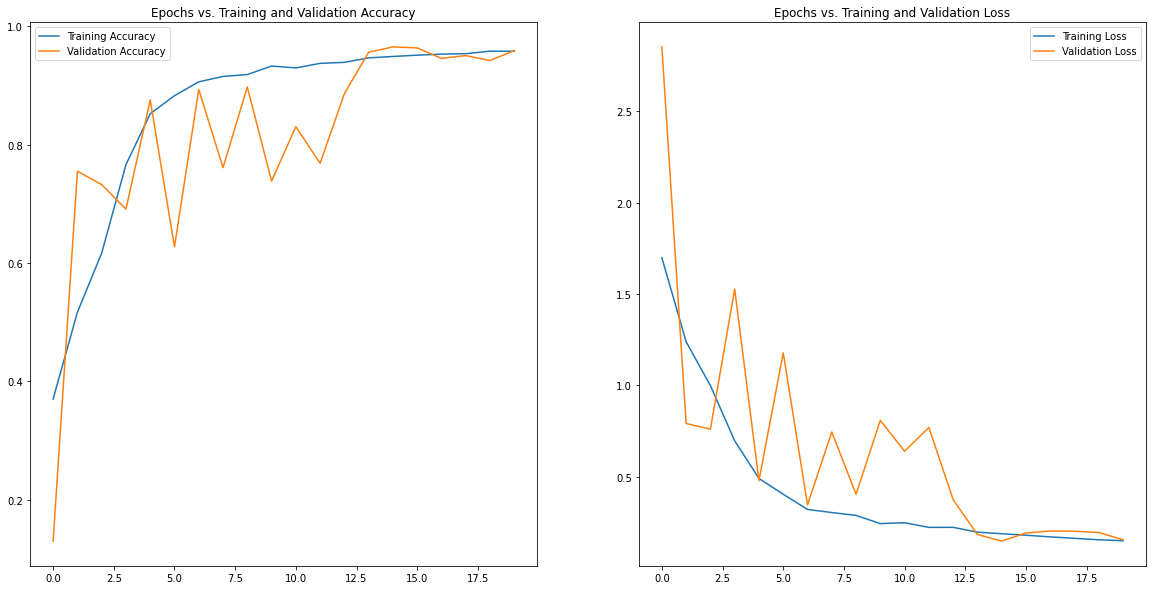

In [54]:
# Visualize epochs vs. train and validation accuracies and losses

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

**Our validation accuracy and loss seem to be rocky, which might indicate that our model has overfit the learning data. Let's see how well it performs on data it has never seen.**

In [60]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(x=test_images, y=test_labels, verbose=0)

print('Test accuracy is: {:0.4f} \nTest loss is: {:0.4f}'.
      format(test_acc, test_loss))

Test accuracy is: 0.5975 
Test loss is: 2.4375


**Our final score is not that glorious, and shows indeed that the model has overfit to the data, and that moreover, our generated images failed to capture the semantics in the original images.**